## Modeling

In [38]:
# libraries for this project
import json
import math
import pandas as pd
import numpy as np
from numpy import mean, std
from IPython.display import HTML
import matplotlib.pyplot as plt
from icecream import ic
#import seaborn as sns
import os.path
import sys
import gc
import feather
from icecream import ic
from sys import getsizeof
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from matplotlib import pyplot
import seaborn as sns

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2

In [39]:
# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

# datetime object containing current date and time
now = datetime.now()

def transf_cat_num(df):

    print("preprocessing: the categorical and numerical feature now...")
    categorical_feature_names = list(df.select_dtypes(include='category').columns)
    numeric_feature_names = list(df.drop(categorical_feature_names, axis=1).columns)
    
    print("One Hot Encoder...")
    print(f'categorical features: {categorical_feature_names}')
    
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))] )
    
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

    # Two preprocessed steps together using the Column Transformer module
    preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_feature_names),
                  ('cat', categorical_transformer, categorical_feature_names)])
    
    return preprocessor

# Install requirements to this project
%pip install freeze
%pip install -r requirements.txt


# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

You should consider upgrading via the '/home/andsilva/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Processing /home/conda/feedstock_root/build_artifacts/aliyun-python-sdk-core_1606717026313/work
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/conda/feedstock_root/build_artifacts/aliyun-python-sdk-core_1606717026313/work'

You should consider upgrading via the '/home/andsilva/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
>>> date:  27/08/2021 08:56:24


In [40]:
print("Loading dataset - to modeling...")

# loading data feather format
df = pd.read_feather('../data/dataset_featuresel.ftr')

Loading dataset - to modeling...


In [41]:
df.dtypes

loan_amnt               float64
term                      int64
installment             float64
grade                     int64
emp_length                int64
home_ownership            int64
annual_inc              float64
verification_status       int64
loan_status               int64
purpose                   int64
title                     int64
addr_state                int64
dti                     float64
delinq_2yrs             float64
earliest_cr_line          int64
inq_last_6mths          float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
last_credit_pull_d        int64
pub_rec_bankruptcies    float64
fico_average            float64
dtype: object

In [42]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 38492
Number of columns..................: 24


## Pipeline Object

In [53]:
def pipeline_project(X, model):
    # Pipeline object
    print("setting the pipeline object ...")
    print('preprocessor...')
    preprocessor = transf_cat_num(X)

    feature_selection = SelectKBest(score_func=mutual_info_regression, k = 22)  

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('fs', feature_selection),
                            ('scaler', StandardScaler()),
                            ('model', model)])

    print('>>> pipeline defined!')    
    return pipe

In [54]:
inbalance_target = dict(df['loan_status'].value_counts(normalize=True).map('{:.2}'.format))

In [55]:
count_neg = float(inbalance_target[0])*100
count_pos = float(inbalance_target[1])*100
scale_inbalance = round(math.sqrt(count_neg/count_pos), 4)
scale_inbalance

0.4035

## Split-out validation dataset

In [56]:
# Regression models
def get_models():
  models['RandomForest']=RandomForestClassifier(n_estimators=50, random_state = 42, n_jobs = -1)
  #models['DecisionTree']=DecisionTreeClassifier()
  #models['KNeighbors']=KNeighborsClassifier()
  models['XGBoost']=xgb.XGBClassifier(random_state=42, 
                                      n_jobs = -1, 
                                      scale_pos_weight = scale_inbalance,
                                      learning_rate = 0.01
                                      )
  models['CatBoost'] = cb.CatBoostClassifier()
  #models['LinearSGDC]= SGDClassifier() # Use all computer cores
  return models

In [57]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d',
       'pub_rec_bankruptcies', 'fico_average'],
      dtype='object')

{'RandomForest': RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42), 'XGBoost': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=0.4035, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), 'CatBoost': <catboost.core.CatBoostClassifier object at 0x7f6f12faee10>}
setting the pipeline object ...
preprocessor...
preprocessing: the categorical and numerical feature now...
One Hot Encoder...
categorical features: []
>>> pipeline defined!
prediction...
>RandomFore

/home/andsilva/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
prediction...
>XGBoost 0.838 (0.000)
memory RAM released.
memory RAM released.
setting the pipeline object ...
preprocessor...
preprocessing: the categorical and numerical feature now...
One Hot Encoder...
categorical features: []
>>> pipeline defined!
Learning rate set to 0.045911
0:	learn: 0.6320915	total: 36.3ms	remaining: 36.2s
1:	learn: 0.5777370	total: 53.6ms	remaining: 26.7s
2:	learn: 0.5338704	total: 123ms	remaining: 40.8s
3:	learn: 0.4974610	total: 162ms	remaining: 40.4s
4:	learn: 0.4639134	total: 203ms	remaining: 40.4s
5:	learn: 0.4354698	total: 250ms	remaining: 41.4s
6:	learn: 0.4126599	total: 328ms	remaining: 46.5s
7:	learn: 0.3947855	total: 371ms	remaining: 46s
8:	learn: 0.3775208	total: 437ms	remaining: 48.1s
9:	learn: 0.364

ic| names: ['RandomForest', 'XGBoost', 'CatBoost']
ic| results: [0.8699202078307664, 0.838188903321581, 0.8678790128038597]


memory RAM released.


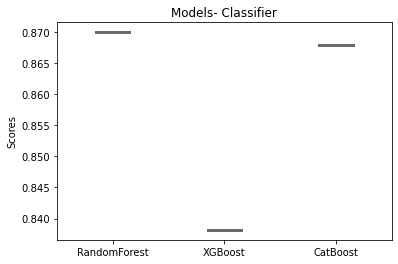

In [58]:
models = {}
models = get_models()

print(models)

# evaluate the models and store results
results = []
names = []

# target name
target_name = 'loan_status'

for name, model in models.items():

    # Alternatively X and y can be obtained directly from the dataframe attribute:
    X = df.drop(target_name, axis=1) # drop the column target
    y = df[target_name] # target

    pipe = pipeline_project(X, model)

    ## Split-out validation dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=1)

    ## Training the model
    #print('training the model...')

    ## Fitting...
    pipe.fit(X_train, y_train)

    ## prediction
    print('prediction...')
    y_pred = pipe.predict(X_test)
    
    scores = accuracy_score(y_test, y_pred, normalize=True)
    
    # store the results
    results.append(scores)

    ## model names
    names.append(name)
    
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

    release_memory(X)
    release_memory(y)

ic(names)
ic(results)

# plot model performance for comparison
sns.boxplot(x=names, y=results, palette="Set3", linewidth=3, width=0.3)
plt.title("Models- Classifier")
plt.ylabel("Scores") # MAE -- Mean Absolute Error
#sns.xlabel("Models")
plt.savefig('pictures/scores_models.png')
plt.show()

[0.04414732754426942, 0.021057357836229747, 0.05276390633795756, 0.02940618505215377, 0.03321132437999755, 0.06595720080684006, 0.013492686890537462, 0.02785328190726166, 0.057868314623175404, 0.03979254260581789, 0.055871582326082345, 0.007686969326433313, 0.0539267241006585, 0.01927921166980204, 0.03646236988859333, 0.004112672161877578, 0.056679677116287186, 0.057619365785371475, 0.04671672779012974, 0.23130443206615645, 0.0035569915516096688, 0.04123314823275783]
features selected:
the K best features selected to the model (RandomForest): ['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d', 'pub_rec_bankruptcies', 'fico_average']
######################################################################
model: RandomForest
loan_amnt.......: 4.41 %
term.......: 2.

/home/andsilva/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


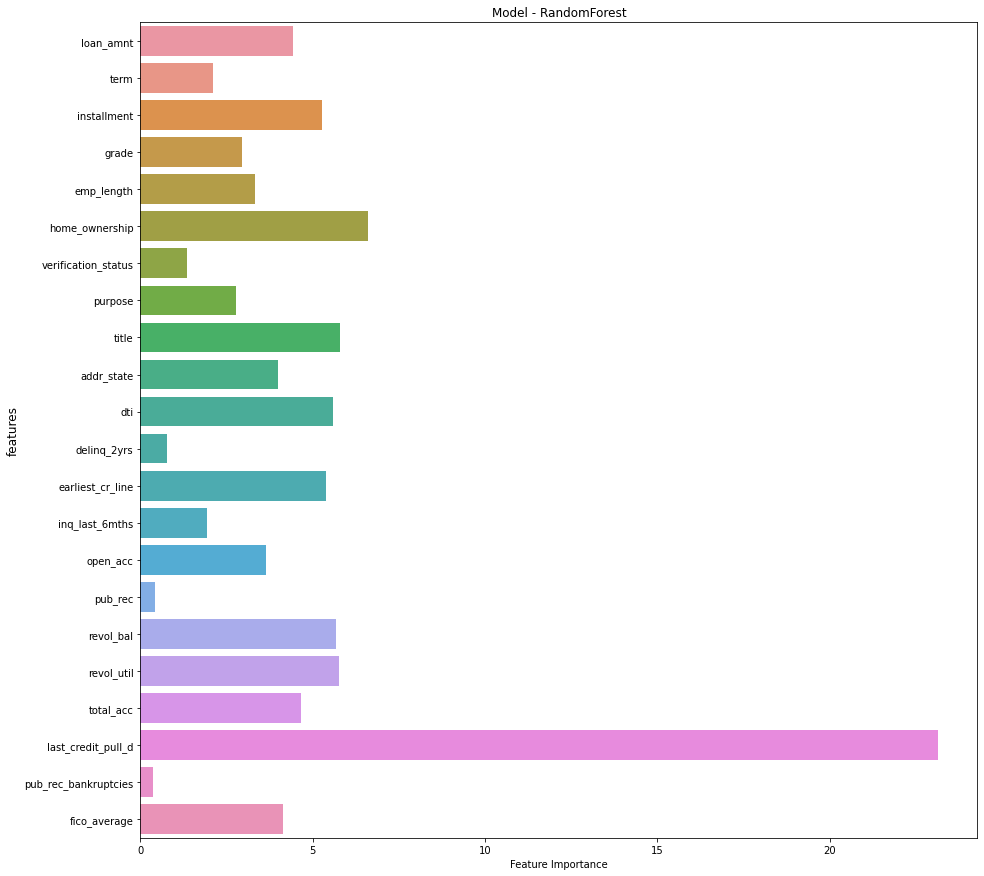

######################################################################
[0.004388561, 0.07752536, 0.0036404782, 0.02433812, 0.012423823, 0.015166724, 0.003203548, 0.00947279, 0.00647841, 0.0042672553, 0.0042836256, 0.0021624544, 0.0027196745, 0.009556433, 0.0023946376, 0.0067226235, 0.0047484254, 0.003723397, 0.0030143165, 0.7947326, 0.0012057929, 0.0038309079]
features selected:
the K best features selected to the model (XGBoost): ['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d', 'pub_rec_bankruptcies', 'fico_average']
######################################################################
model: XGBoost
loan_amnt.......: 0.44 %
term.......: 7.75 %
installment.......: 0.36 %
grade.......: 2.43 %
emp_length.......: 1.24 %
home_ownership.......: 1.52 %
verificati

/home/andsilva/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


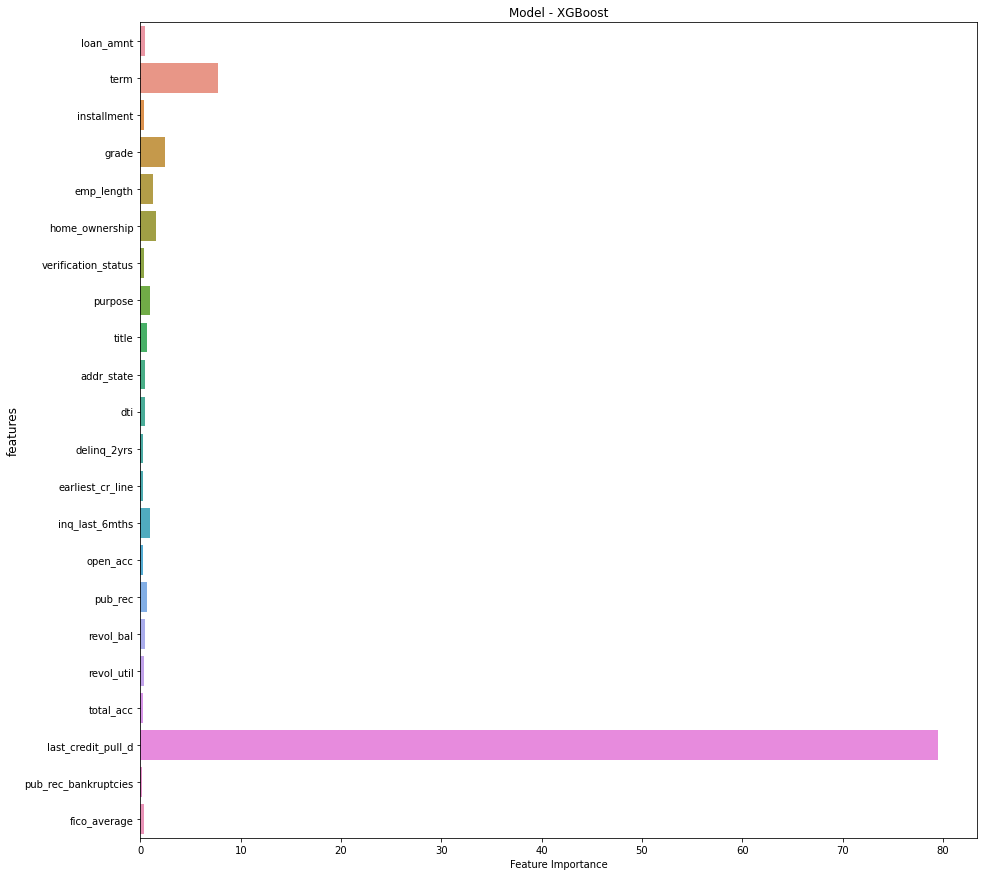

######################################################################
[2.4089685138109007, 1.8932774272879387, 3.6201336694060875, 2.951022522926856, 3.231082011403328, 1.2365887092079584, 1.382691319736605, 3.389534212178794, 5.875706459501087, 3.793301028752779, 3.6173329644563625, 0.6015925155427467, 4.109887110048985, 2.175505418302349, 2.6691710051901394, 0.2569052075556333, 4.854397845844836, 4.165178752351377, 4.557302644631649, 39.536459961291676, 0.2744568214081385, 3.399503879163792]
features selected:
the K best features selected to the model (CatBoost): ['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d', 'pub_rec_bankruptcies', 'fico_average']
######################################################################
model: CatBoost
loan_amnt.......: 2.

/home/andsilva/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


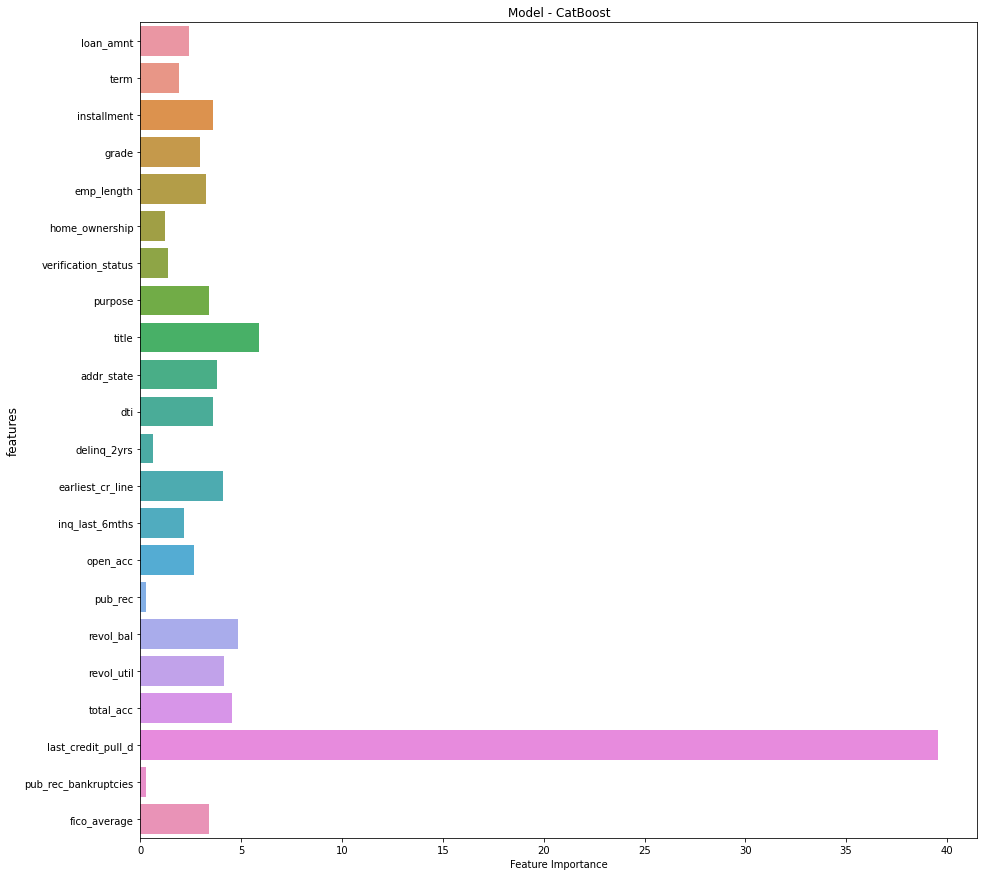

######################################################################


In [62]:
feature_names =list(X.columns)

# feature importance
for name, model in models.items():

    if(name == 'LinearR'):
        continue

    list_feat_importances = list(model.feature_importances_)
    print(list_feat_importances)
    
    dict_feat_importances = {}

    print('features selected:')
    mask = pipe.named_steps['fs'].get_support()

    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, feature_names):
        if(bool):
            new_features.append(feature)
            
    print(f'the K best features selected to the model ({name}): {new_features}')

    i=0

    print('######################################################################')
    print(f'model: {name}')

    # list of feature importances
    for ilist in new_features:

        if(name=='CatBoost'):
            dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1
        else:
            dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1

    x_axis = list(dict_feat_importances.values())
    y_axis = list(dict_feat_importances.keys())

    plt.figure(figsize = (15,15))
    sns.barplot(x_axis, y_axis)
    
    plt.ylabel('features', fontsize=12)
    plt.xlabel('Feature Importance')
    plt.title(f"Model - {name}")
    plt.savefig(f'figures/feature_importance_model_{name}.png')
    plt.savefig(f'figures/feature_importance_model_{name}.pdf')
    # Show graphic
    plt.show()


    print('######################################################################')


In [63]:
# time of execution in minutes
time_exec_min = round( (time.time() - start_time)/60, 4)

print(f'time of execution (preprocessing): {time_exec_min} minutes')
print("the preprocessing is done.")
print("The next step is to do the modeling.")

# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

print("All Done. :)")

time of execution (preprocessing): 19.4126 minutes
the preprocessing is done.
The next step is to do the modeling.
>>> date:  27/08/2021 09:15:49
All Done. :)
